#Load and summarize dataset

In [104]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.pandas.set_option("display.max_columns", None)
df = pd.read_csv("https://raw.githubusercontent.com/Jaiprakash91194/CTR_Email_Campaign/main/train_data.csv")
df.head()

,campaign_id,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,no_of_CTA,mean_CTA_len,is_image,is_personalised,is_quote,is_timer,is_emoticons,is_discount,is_price,is_urgency,target_audience,click_rate
0,1,3,76,10439,39,5,1,Noon,6,26,3,29,0,0,0,0,0,0,0,0,14,0.103079
1,2,3,54,2570,256,5,1,Morning,2,11,0,22,0,0,0,0,0,0,0,0,10,0.700000
2,3,3,59,12801,16,5,1,Noon,2,11,3,23,1,0,1,0,0,0,0,0,16,0.002769
3,4,3,74,11037,30,4,0,Evening,15,9,4,24,0,0,0,0,0,0,0,0,10,0.010868
4,5,3,80,10011,27,5,1,Noon,6,26,3,31,0,0,1,0,0,0,0,0,14,0.142826


#Exploratory Data Analysis
Lets perform EDA to understand more about the data:
- Missing Values
- All the Numerical Variables
- Distribution of Numerical Variables(Since this is regression problem, we need to check the  distribution data whether the distribution is skewed)
- Categorical Variables
- Cardinality of Categorical Variables
- Outliers
- Relationship between independent and dependent variables(Click Rate).

In [105]:
#Missing values - Lets check whether we have any missing values in the dataset and handle them
df.isna().sum()

campaign_id           0
sender                0
subject_len           0
body_len              0
mean_paragraph_len    0
day_of_week           0
is_weekend            0
times_of_day          0
category              0
product               0
no_of_CTA             0
mean_CTA_len          0
is_image              0
is_personalised       0
is_quote              0
is_timer              0
is_emoticons          0
is_discount           0
is_price              0
is_urgency            0
target_audience       0
click_rate            0
dtype: int64

campaigh_id is unique and will lead to overfitting. Hence removing the feature

In [106]:
df.drop("campaign_id", axis=1, inplace=True)

From above data, we see there are no missing values in our dataset.

In [107]:
qualitative_features = []
quantitative_features = []
for feature in df.columns:
  if len(df[feature].unique()) < 25:
    qualitative_features.append(feature)
    print("Feature: {} has {} classes --> {}".format(feature, len(df[feature].unique()), sorted(df[feature].unique())))
  else:
    quantitative_features.append(feature)

Feature: sender has 12 classes --> [0, 1, 2, 3, 6, 7, 9, 10, 11, 12, 14, 15]
Feature: day_of_week has 7 classes --> [0, 1, 2, 3, 4, 5, 6]
Feature: is_weekend has 2 classes --> [0, 1]
Feature: times_of_day has 3 classes --> ['Evening', 'Morning', 'Noon']
Feature: category has 16 classes --> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Feature: is_image has 6 classes --> [0, 1, 2, 3, 4, 6]
Feature: is_personalised has 2 classes --> [0, 1]
Feature: is_quote has 7 classes --> [0, 1, 2, 3, 4, 5, 6]
Feature: is_timer has 1 classes --> [0]
Feature: is_emoticons has 6 classes --> [0, 1, 2, 3, 4, 6]
Feature: is_discount has 2 classes --> [0, 1]
Feature: is_price has 8 classes --> [0, 1000, 1399, 4999, 5000, 5499, 8000, 14999]
Feature: is_urgency has 2 classes --> [0, 1]
Feature: target_audience has 17 classes --> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


From above data we see "is_timer" columns has only one class and is not going to affect the output class. Hence we can drop the feature.

In [108]:
df.drop("is_timer", axis=1, inplace=True)
qualitative_features.remove("is_timer")

#Feature Engineering

Segregate the Numerical features and Categorical features

In [109]:
pd.DataFrame(df.dtypes.value_counts()).T

,int64,object,float64
0,18,1,1


There are 19 Integer feature and 1 Object feature.

Lets segregate the features with unique classess less than 25 as qualitative features and check the relationship between feature categorical feature and target. Also relationship between a feature and target.

In [110]:
integer_data_cols = df.select_dtypes(include="int64").columns
object_data_cols = df.select_dtypes(include="object").columns

Lets check the distribution Object feature(TimesOfDay) and apply required encoding to convert them to Numeric feature

In [111]:
df['times_of_day'].value_counts()

Evening    1317
Noon        447
Morning     124
Name: times_of_day, dtype: int64

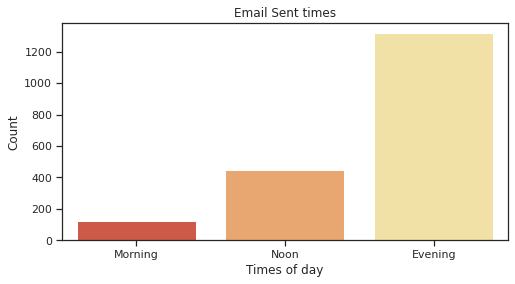

In [112]:
plt.figure(figsize=(8,4))
sns.set_theme(style='ticks',palette='RdYlGn')

sns.countplot(df['times_of_day'],order=df['times_of_day'].value_counts().index[::-1])
plt.xlabel('Times of day')
plt.ylabel('Count')
plt.title('Email Sent times')
plt.show()

Since the data is Ordinal, lets apply Label Encoding the convert the features to Numeric 

--> Evening(2), Noon(1), Morning(0)

In [113]:
df['times_of_day'] = df['times_of_day'].map({"Evening": 2, "Noon": 1, "Morning": 0}).astype("int64")

In [114]:
qualitative_features

['sender',
 'day_of_week',
 'is_weekend',
 'times_of_day',
 'category',
 'is_image',
 'is_personalised',
 'is_quote',
 'is_emoticons',
 'is_discount',
 'is_price',
 'is_urgency',
 'target_audience']

In [115]:
boolean_features = df.filter(like='is').columns
boolean_features

Index(['is_weekend', 'is_image', 'is_personalised', 'is_quote', 'is_emoticons',
       'is_discount', 'is_price', 'is_urgency'],
      dtype='object')

#Interpretations:
As mentioned in the data description the features like ('is_weekend', 'is_image', 'is_personalised', 'is_quote', 'is_emoticons','is_discount', 'is_price', 'is_urgency') are **Boolean values**. But few boolean columns has outliers other than 0 and 1.

So we encoding these values into 0 and 1(data greater than 1 into 1)

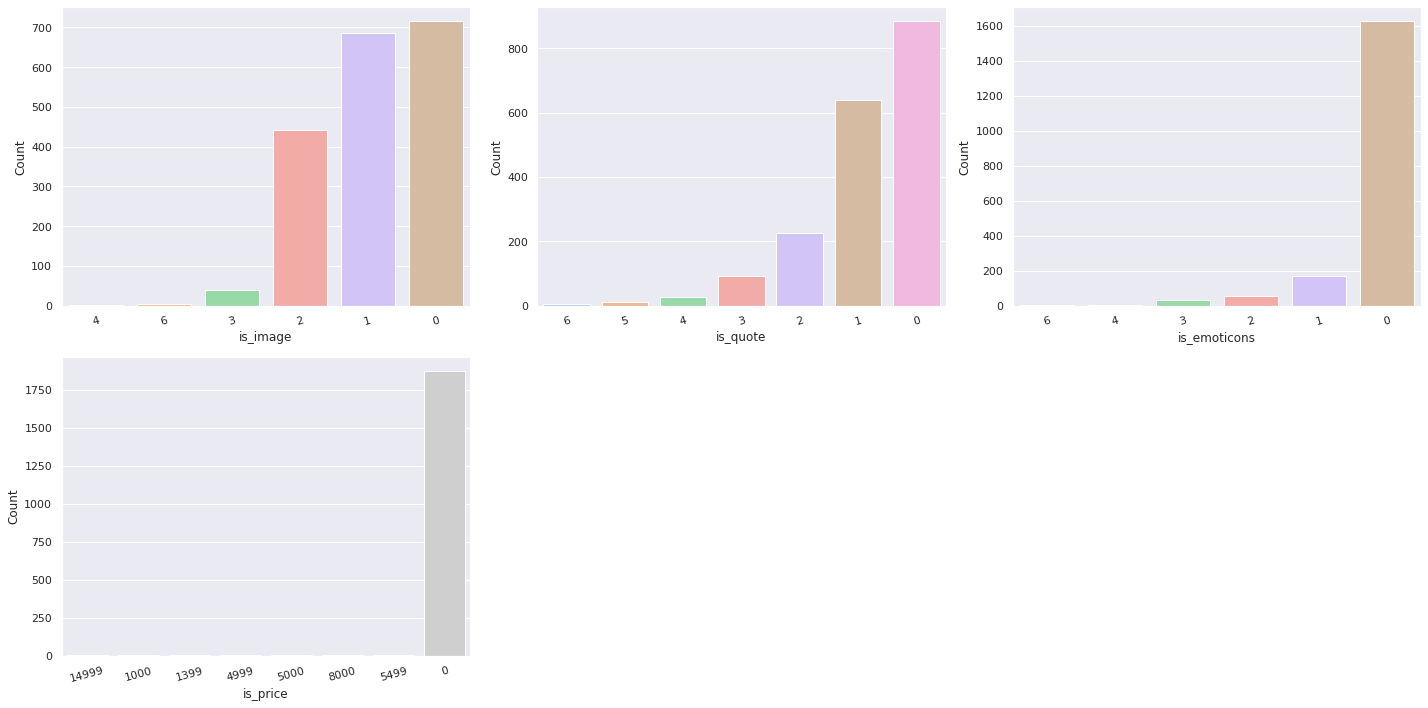

In [116]:
sns.set_theme(style='darkgrid',palette='pastel')

try:
  plt.figure(figsize=(20,10))
  i = 230
  for feature in boolean_features:
    if len(df[feature].unique()) > 2:
      i += 1
      plt.subplot(i)
      sns.countplot(df[feature], order=df[feature].value_counts().index[::-1])
      plt.xticks(rotation=15)
      plt.xlabel(feature)
      plt.ylabel("Count")
except ValueError:
  pass

plt.tight_layout()
plt.show()

In [117]:
df["is_price"].value_counts()

0        1875
5499        5
8000        2
5000        2
4999        1
1399        1
1000        1
14999       1
Name: is_price, dtype: int64

From above visualization, we see the values other an boolean values are negligible comparing to 0 and 1. Hence replacing the values greater than 1 into 1(As it represent true value for the data)

In [118]:
for feature in boolean_features:
  df.loc[df[feature] > 1, feature] = 1  

In [119]:
for feature in boolean_features:
  if len(df[feature].unique()) > 2: 
    print(feature)

There is very less relationship for the feature: "is_price" to the Target variable. So removing the feature: "is_price"

In [120]:
df.drop("is_price", axis=1, inplace=True)
qualitative_features.remove("is_price")

#Data Visualization
#Feature vs Target
Lets check the relationship of each feature with target

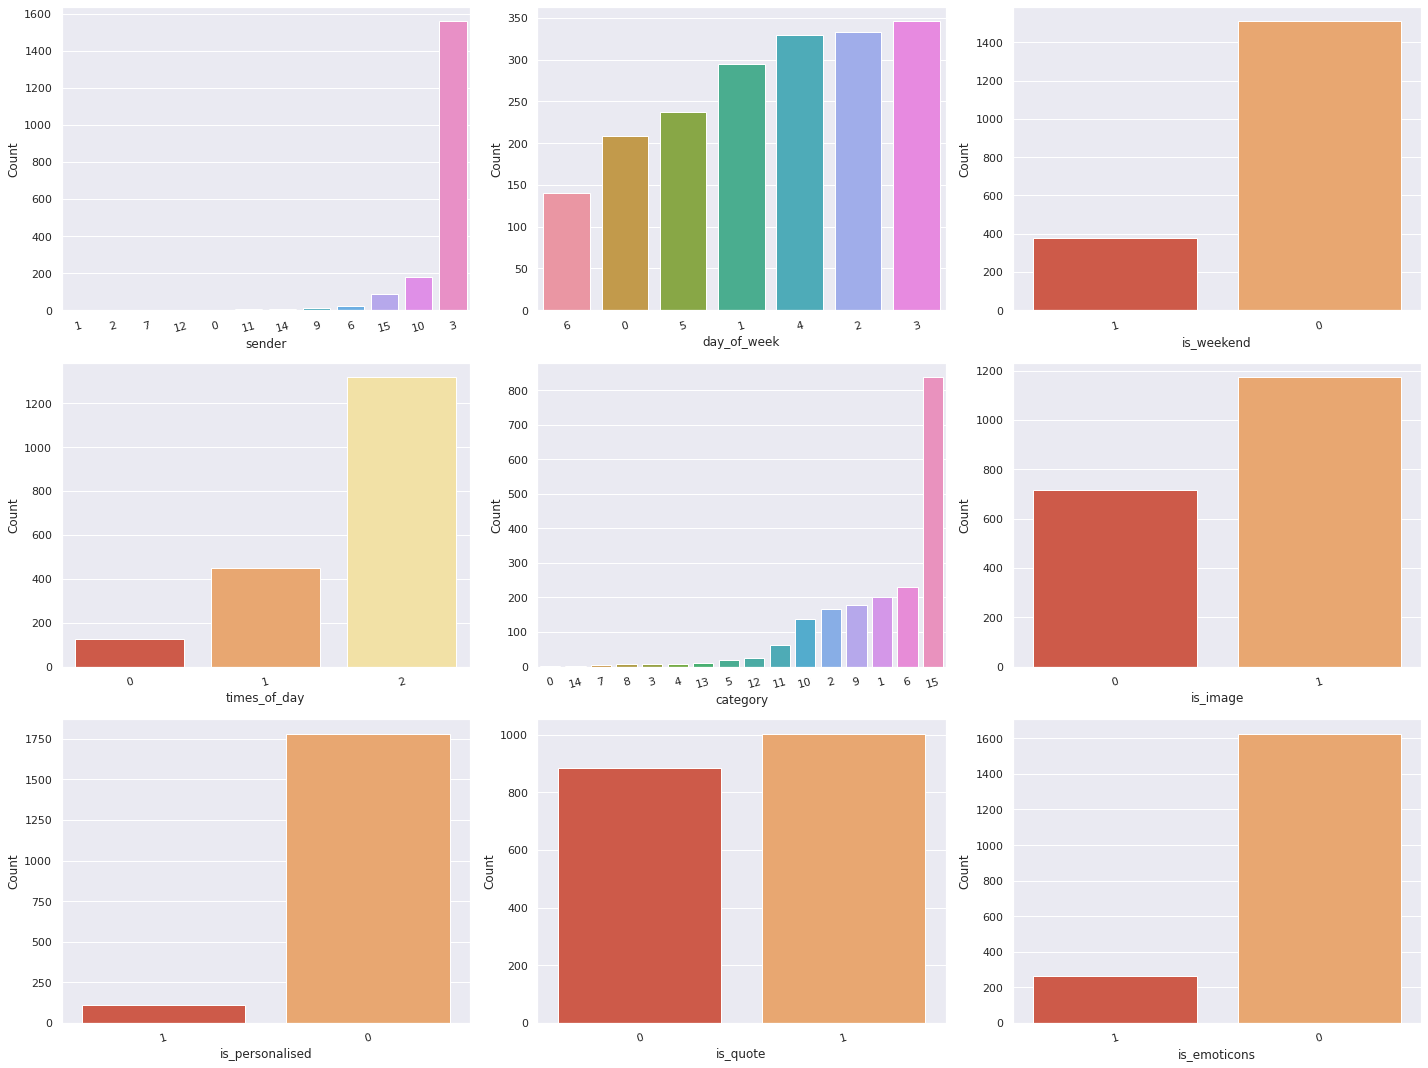

In [121]:
sns.set_theme(style='darkgrid',palette='RdYlGn')

try:
  plt.figure(figsize=(20,15))
  i = 330
  for feature in qualitative_features[:10]:
    i += 1
    plt.subplot(i)
    sns.countplot(df[feature], order=df[feature].value_counts().index[::-1])
    plt.xticks(rotation=15)
    plt.xlabel(feature)
    plt.ylabel("Count")
except ValueError:
  pass

plt.tight_layout()
plt.show()

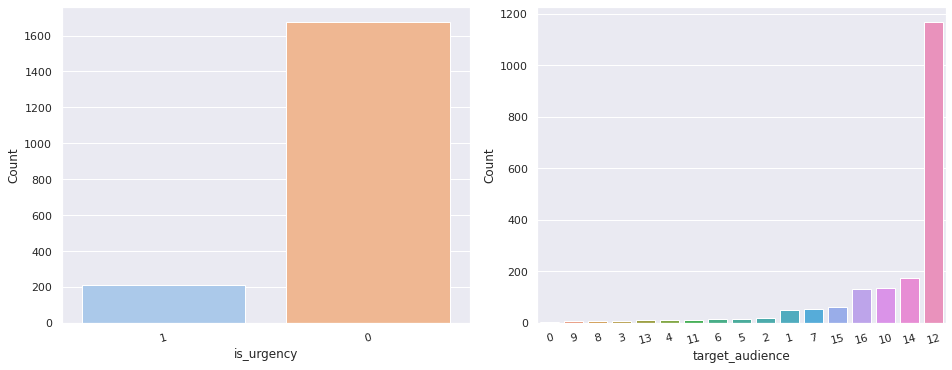

In [122]:
sns.set_theme(style='darkgrid',palette='pastel')

try:
  plt.figure(figsize=(20,15))
  i = 330
  for feature in qualitative_features[10:]:
    i += 1
    plt.subplot(i)
    sns.countplot(df[feature], order=df[feature].value_counts().index[::-1])
    plt.xticks(rotation=15)
    plt.xlabel(feature)
    plt.ylabel("Count")
except ValueError:
  pass

plt.tight_layout()
plt.show()

Since Campaign_ID is unique, lets remove the feature as it will lead to overfitting

Also remove click_rate as that is the target variable to be predicted by the model.

Since Clickrate is the Target variable, lets remove the feature from quantitative features  list

In [123]:
quantitative_features.remove("click_rate")

#Handle Outliers
Since most of the Regression models(Linear Regression, KNN, SVR etc) are sensitive to Outliers, lets check the distribution of data and handle the outliers.

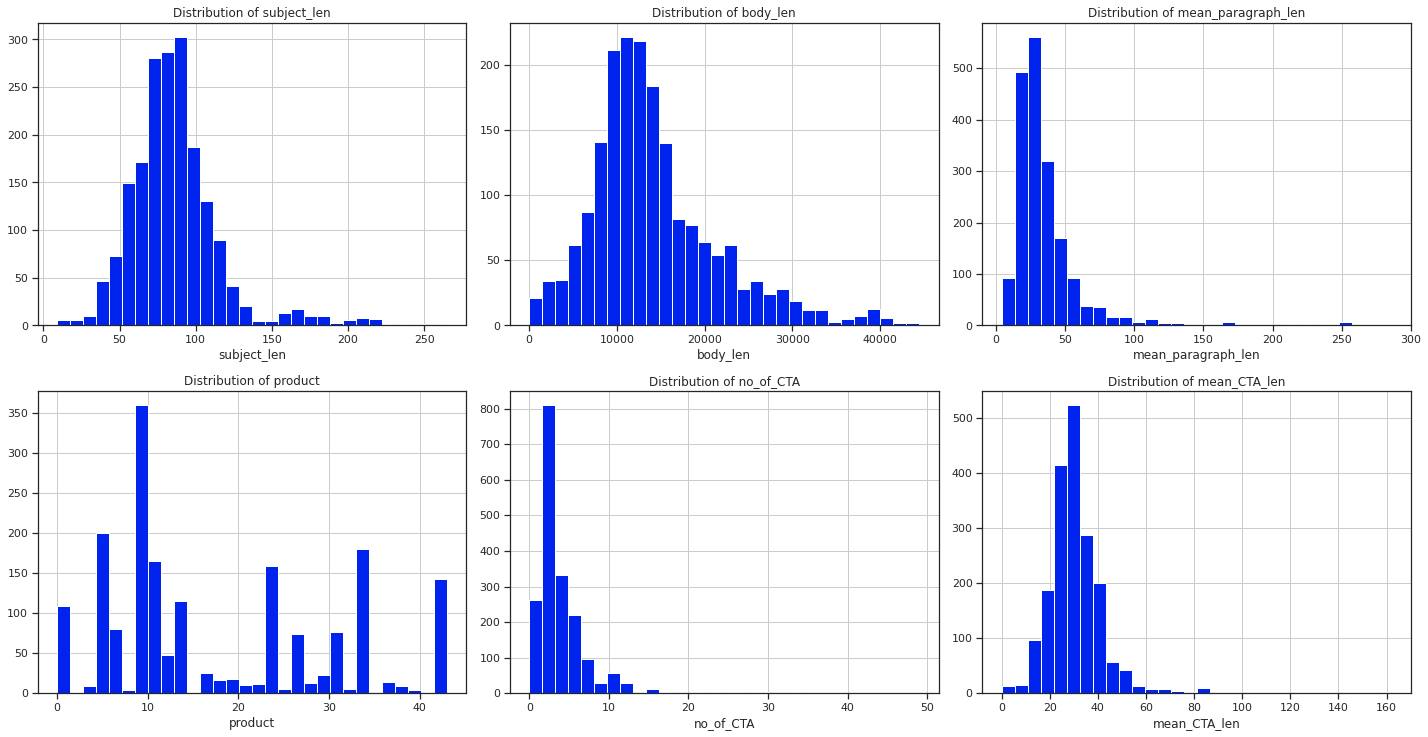

In [124]:
sns.set_theme(style='ticks',palette="winter")
i = 330
plt.figure(figsize=(20,15))
for feature in quantitative_features:
  i += 1
  plt.subplot(i)
  df[feature].hist(bins=30)
  title1="Distribution of " + feature
  plt.xlabel(feature)
  plt.title(title1)

plt.tight_layout()
plt.show()

From above graph, below is the distribution of data

**Normal Distribution:** subject_len, body_len

**Skewed Distribution:** mean_paragraph_len, no_of_CTA, mean_CTA_len

In [125]:
df["subject_len"].describe()

count    1888.000000
mean       86.246292
std        30.143206
min         9.000000
25%        69.000000
50%        83.000000
75%        98.000000
max       265.000000
Name: subject_len, dtype: float64

The feature: subject_len  is Normally Distributed, but there are Outliers in the data with:
- Mean: 86.24
- Max value: 265

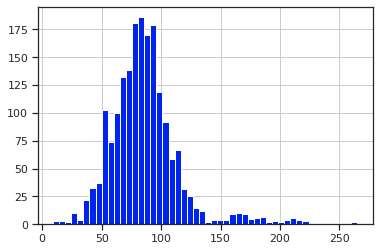

In [126]:
df.subject_len.hist(bins=50)

**Gaussian Distribution Outliers**

If the feature follows a Gaussian Distribution, we calculate the boundaries which differentiate the outliers.

**Skewed Distribution Outliers**

In case of Skewed Distribution, lets calculate the IQR to differentiate the Outliers

In [127]:
sns.set_theme(style='whitegrid',palette='winter')

def plot_graph(dataframe, dataframe1, feature):
  plt.figure(figsize=(15,6))
  plt.subplot(121)
  sns.distplot(dataframe[feature])
  plt.title("Distribution of feature with Outlier")
  plt.subplot(122)
  sns.distplot(dataframe1[feature])
  plt.title("Distribution of feature after removing outliers")

def handle_outlier(feature):
  data = df.copy()
  IQR = df[feature].quantile(0.75) - df[feature].quantile(0.25)
  lower_fence = df.quantile(0.25) - 1.5*IQR
  upper_fence = df[feature].quantile(0.75) + 1.5*IQR
  data.loc[data[feature] > upper_fence, feature] = int(upper_fence)
  plot_graph(df, data, feature)
  plt.tight_layout()
  plt.show()
  df[feature] = data[feature]


In [128]:
quantitative_features

['subject_len',
 'body_len',
 'mean_paragraph_len',
 'product',
 'no_of_CTA',
 'mean_CTA_len']

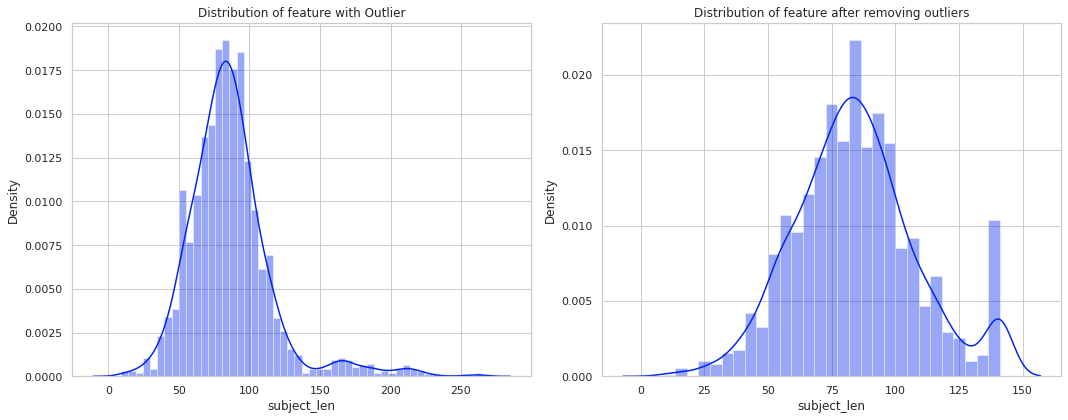

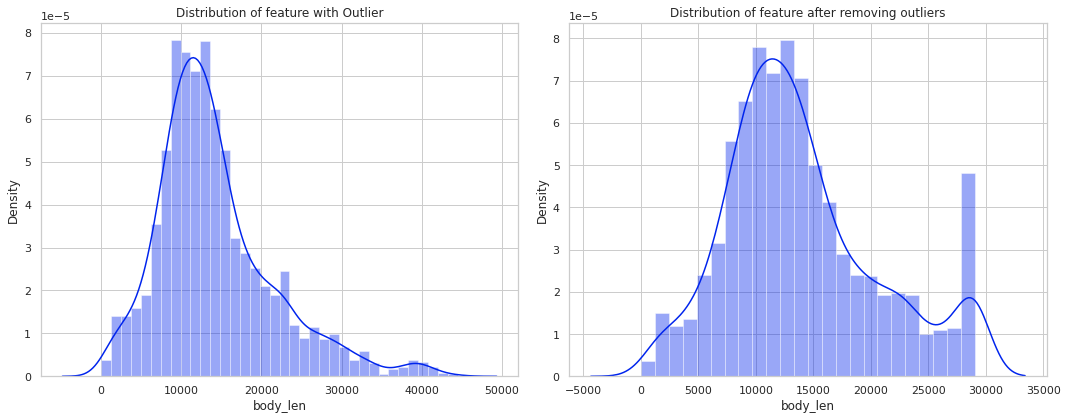

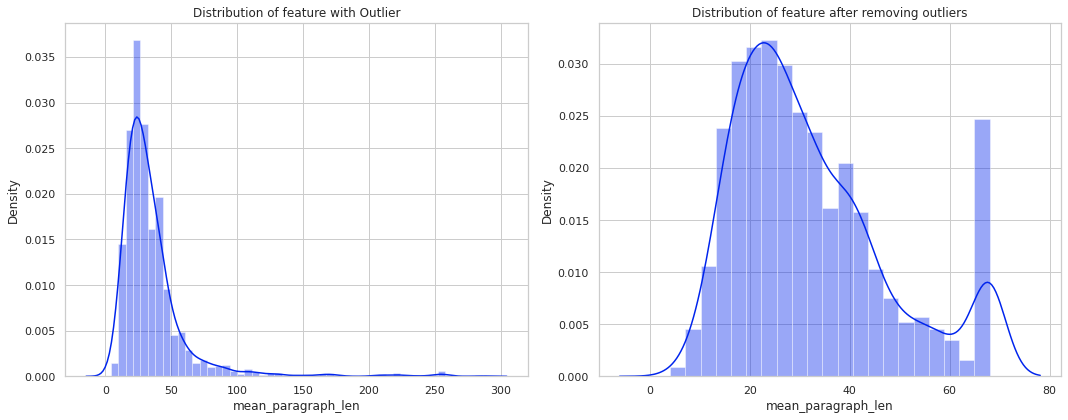

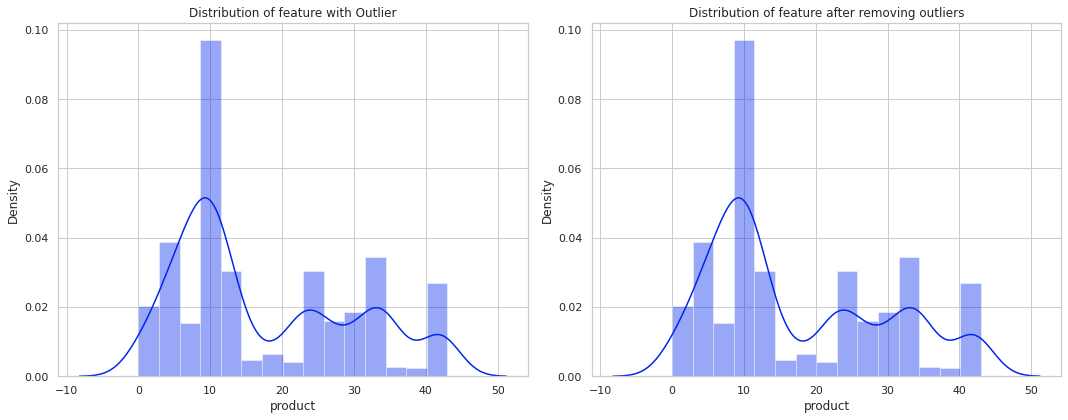

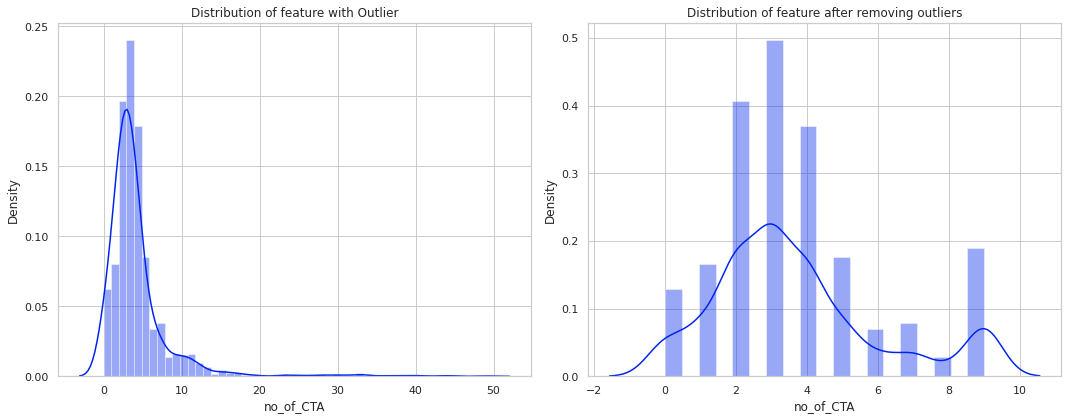

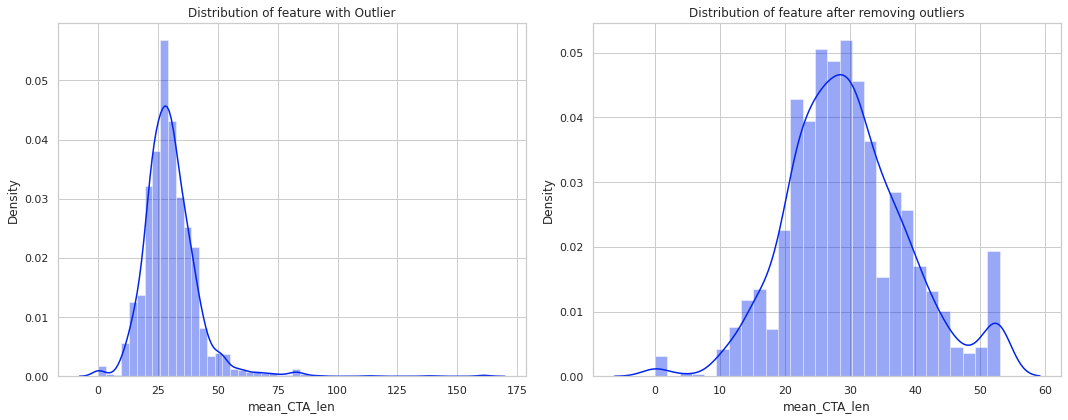

In [129]:
for feature in quantitative_features:
  handle_outlier(feature)

In [130]:
df["subject_len"].describe()

count    1888.000000
mean       84.314089
std        24.067899
min         9.000000
25%        69.000000
50%        83.000000
75%        98.000000
max       141.000000
Name: subject_len, dtype: float64

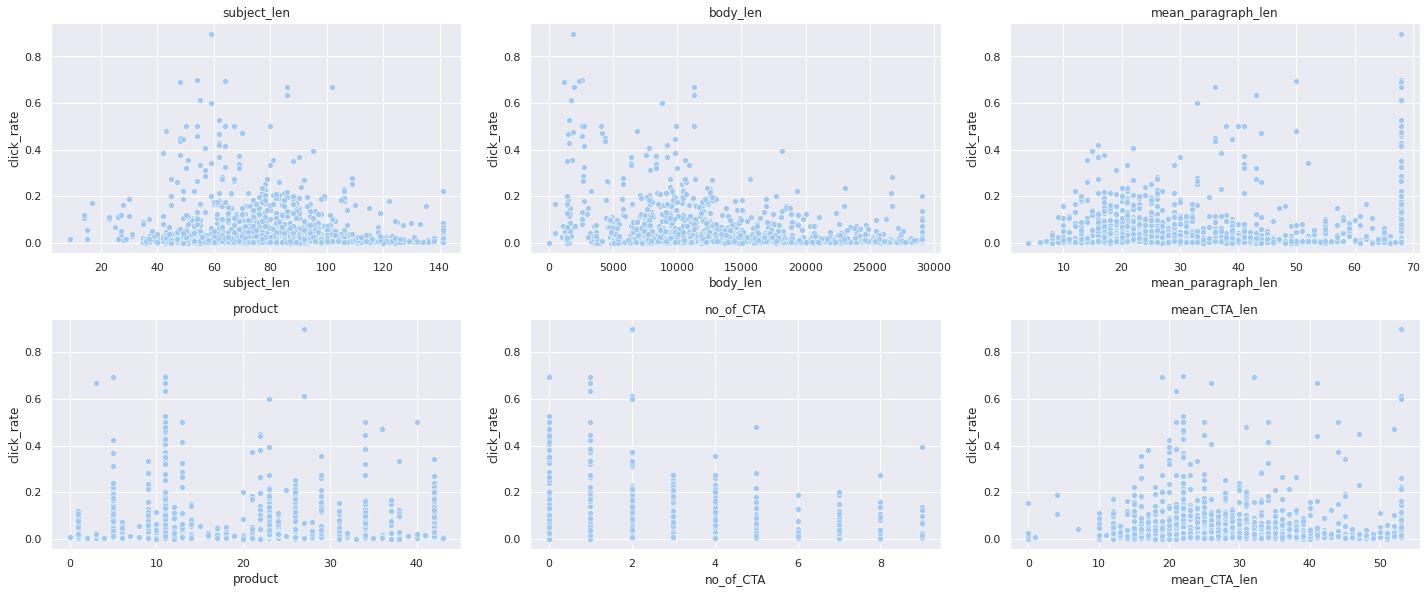

In [131]:
sns.set_theme(style="darkgrid",palette="pastel")
plt.figure(figsize=(20, 12))
i = 330
for feature in quantitative_features:
  i += 1
  plt.subplot(i)
  sns.scatterplot(df[feature],df['click_rate'])
  title1 = feature + "vs click_rate"
  plt.title(feature)
  
plt.tight_layout()
plt.show()

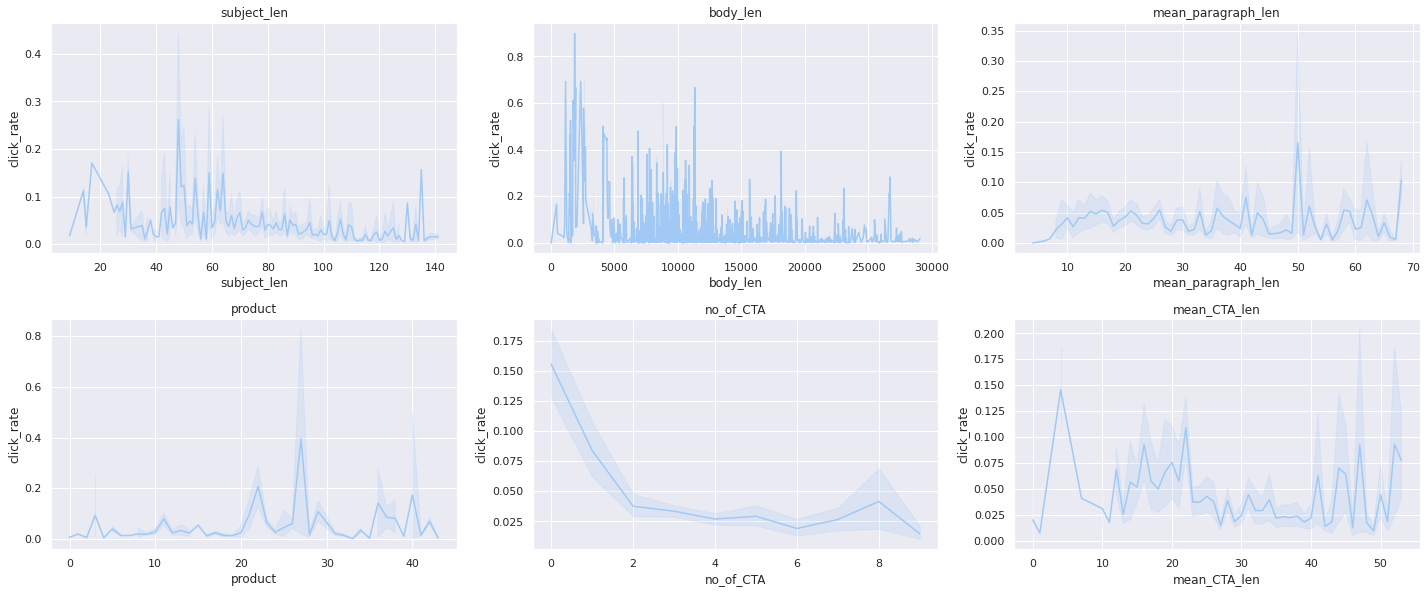

In [132]:
sns.set_theme(style="darkgrid",palette="pastel")
plt.figure(figsize=(20, 12))
i = 330
for feature in quantitative_features:
  i += 1
  plt.subplot(i)
  sns.lineplot(df[feature],df['click_rate'])
  title1 = feature + "vs click_rate"
  plt.title(feature)
  
plt.tight_layout()
plt.show()

In [134]:
for feature in df.columns:
  if len(df[feature].unique()) < 25:
    qualitative_features.append(feature)
    print("Feature: {} has {} classes --> {}".format(feature, len(df[feature].unique()), sorted(df[feature].unique())))

Feature: sender has 12 classes --> [0, 1, 2, 3, 6, 7, 9, 10, 11, 12, 14, 15]
Feature: day_of_week has 7 classes --> [0, 1, 2, 3, 4, 5, 6]
Feature: is_weekend has 2 classes --> [0, 1]
Feature: times_of_day has 3 classes --> [0, 1, 2]
Feature: category has 16 classes --> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Feature: no_of_CTA has 10 classes --> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Feature: is_image has 2 classes --> [0, 1]
Feature: is_personalised has 2 classes --> [0, 1]
Feature: is_quote has 2 classes --> [0, 1]
Feature: is_emoticons has 2 classes --> [0, 1]
Feature: is_discount has 2 classes --> [0, 1]
Feature: is_urgency has 2 classes --> [0, 1]
Feature: target_audience has 17 classes --> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [136]:
#orders for all the barplots in ascending order
sender = df.groupby('sender')['click_rate'].mean().reset_index().sort_values('click_rate')['sender']
day_of_week = df.groupby('day_of_week')['click_rate'].mean().reset_index().sort_values('click_rate')['day_of_week']
times_of_day = df.groupby('times_of_day')['click_rate'].mean().reset_index().sort_values('click_rate')['times_of_day']
category = df.groupby('category')['click_rate'].mean().reset_index().sort_values('click_rate')['category']
is_image = df.groupby('is_image')['click_rate'].mean().reset_index().sort_values('click_rate')['is_image']
is_quote = df.groupby('is_quote')['click_rate'].mean().reset_index().sort_values('click_rate')['is_quote']
is_image = df.groupby('is_image')['click_rate'].mean().reset_index().sort_values('click_rate')['is_image']
is_emoticons = df.groupby('is_emoticons')['click_rate'].mean().reset_index().sort_values('click_rate')['is_emoticons']
target_audience = df.groupby('target_audience')['click_rate'].mean().reset_index().sort_values('click_rate')['target_audience']

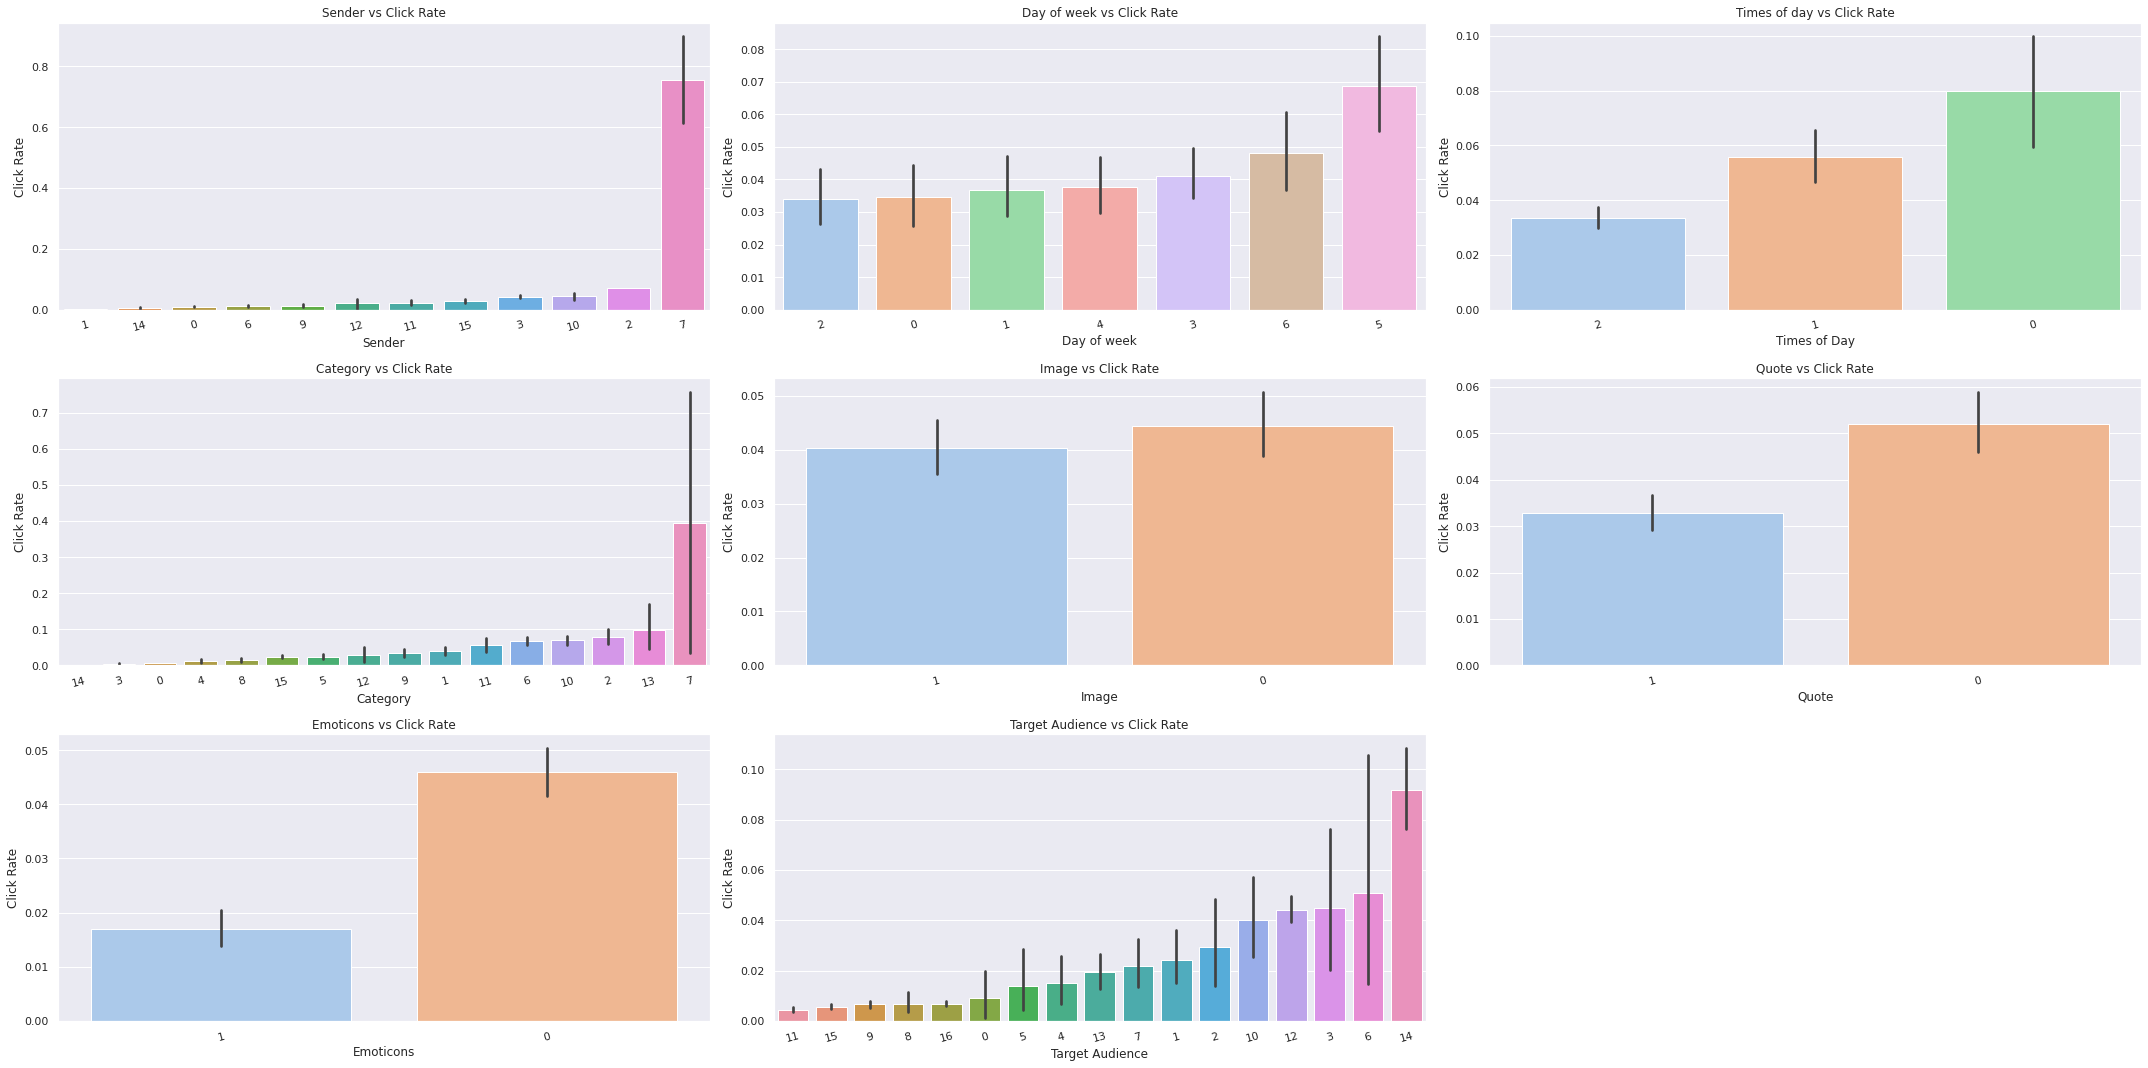

In [137]:
#plotting count plots for all the categorical columns
sns.set_theme(style='darkgrid',palette='pastel')

plt.figure(figsize=(30,15))

plt.subplot(331)
sns.barplot(df['sender'],df['click_rate'],order=sender)
plt.xticks(rotation=15)
plt.xlabel('Sender')
plt.ylabel('Click Rate')
plt.title('Sender vs Click Rate')

plt.subplot(332)
sns.barplot(df['day_of_week'],df['click_rate'],order=day_of_week)
plt.xticks(rotation=15)
plt.xlabel('Day of week')
plt.ylabel('Click Rate')
plt.title('Day of week vs Click Rate')

plt.subplot(333)
sns.barplot(df['times_of_day'],df['click_rate'],order=times_of_day)
plt.xticks(rotation=15)
plt.xlabel('Times of Day')
plt.ylabel('Click Rate')
plt.title('Times of day vs Click Rate')

plt.subplot(334)
sns.barplot(df['category'],df['click_rate'],order=category)
plt.xticks(rotation=15)
plt.xlabel('Category')
plt.ylabel('Click Rate')
plt.title('Category vs Click Rate')

plt.subplot(335)
sns.barplot(df['is_image'],df['click_rate'],order=is_image)
plt.xticks(rotation=15)
plt.xlabel('Image')
plt.ylabel('Click Rate')
plt.title('Image vs Click Rate')

plt.subplot(336)
sns.barplot(df['is_quote'],df['click_rate'],order=is_quote)
plt.xticks(rotation=15)
plt.xlabel('Quote')
plt.ylabel('Click Rate')
plt.title('Quote vs Click Rate')

plt.subplot(337)
sns.barplot(df['is_emoticons'],df['click_rate'],order=is_emoticons)
plt.xticks(rotation=15)
plt.xlabel('Emoticons')
plt.ylabel('Click Rate')
plt.title('Emoticons vs Click Rate')

plt.subplot(338)
sns.barplot(df['target_audience'],df['click_rate'],order=target_audience)
plt.xticks(rotation=15)
plt.xlabel('Target Audience')
plt.ylabel('Click Rate')
plt.title('Target Audience vs Click Rate')


plt.tight_layout()
plt.show()

In [138]:
df

,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,no_of_CTA,mean_CTA_len,is_image,is_personalised,is_quote,is_emoticons,is_discount,is_urgency,target_audience,click_rate
0,3,76,10439,39,5,1,1,6,26,3,29,0,0,0,0,0,0,14,0.103079
1,3,54,2570,68,5,1,0,2,11,0,22,0,0,0,0,0,0,10,0.700000
2,3,59,12801,16,5,1,1,2,11,3,23,1,0,1,0,0,0,16,0.002769
3,3,74,11037,30,4,0,2,15,9,4,24,0,0,0,0,0,0,10,0.010868
4,3,80,10011,27,5,1,1,6,26,3,31,0,0,1,0,0,0,14,0.142826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1883,3,88,1451,68,2,0,1,2,11,0,22,0,0,1,0,0,0,10,0.350746
1884,3,58,10537,40,2,0,2,2,11,5,27,0,0,0,0,0,0,11,0.004728
1885,3,89,11050,26,1,0,2,15,9,4,28,0,0,0,0,0,0,6,0.008289
1886,3,58,10537,40,1,0,2,2,11,5,27,0,0,0,0,0,0,16,0.012014


#Segregating Dataset into X & Y

In [139]:
x_train = df.drop("click_rate",axis=1)
y_train = df["click_rate"]

In [140]:
df_test = pd.read_csv("https://raw.githubusercontent.com/Jaiprakash91194/CTR_Email_Campaign/main/test_data.csv")

#Feature Engineering in Training data
Below are the Feature Engineering techniques performed on Training data:

**Encoding**:
- times_of_day --> Since data is Ordinal, mapped the text data to numeric based on the data weightage --> **Evening(2), Noon(1), Morning(0)**

**Features Selection:**
- campaign_id --> Removed since it will lead to model overfitting
- is_timer --> Removed as it has only one class, and Doesn't affect the performance of the model.
- is_price --> Removed as the contribution of Boolean value(True) is negligible comparing to 1.

**Boolean Value convertion:**

- As mentioned in the data description the features like ('is_weekend', 'is_image', 'is_personalised', 'is_quote', 'is_emoticons','is_discount', 'is_price', 'is_urgency') are Boolean values. But few boolean columns has outliers other than 0 and 1.

- So we are  encoding these values into 0 and 1(data greater than 1 into 1)

In [141]:
def feature_eng(dataframe):
  dataframe['times_of_day'] = dataframe['times_of_day'].map({"Evening": 2, "Noon": 1, "Morning": 0}).astype("int64")
  for feature in dataframe.filter(like='is').columns:
    dataframe.loc[dataframe[feature] > 1, feature] = 1 
  dataframe.drop(["campaign_id", "is_timer", "is_price"], axis=1, inplace=True)
  return dataframe

In [142]:
df_test1 = pd.read_csv("https://raw.githubusercontent.com/Jaiprakash91194/CTR_Email_Campaign/main/test_data.csv")
df_test = feature_eng(df_test1)

In [143]:
df_test.head()

,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,no_of_CTA,mean_CTA_len,is_image,is_personalised,is_quote,is_emoticons,is_discount,is_urgency,target_audience
0,3,61,12871,11,6,1,1,6,26,3,37,1,0,0,1,0,0,14
1,3,54,2569,256,5,1,0,2,11,0,22,0,0,0,0,0,0,10
2,3,88,1473,78,4,0,2,2,11,0,22,1,0,1,0,0,0,10
3,3,88,1473,78,3,0,2,2,11,0,22,1,0,1,0,0,0,10
4,3,78,9020,29,3,0,1,6,26,2,40,0,0,0,0,0,0,14


In [144]:
df.head()

,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,no_of_CTA,mean_CTA_len,is_image,is_personalised,is_quote,is_emoticons,is_discount,is_urgency,target_audience,click_rate
0,3,76,10439,39,5,1,1,6,26,3,29,0,0,0,0,0,0,14,0.103079
1,3,54,2570,68,5,1,0,2,11,0,22,0,0,0,0,0,0,10,0.700000
2,3,59,12801,16,5,1,1,2,11,3,23,1,0,1,0,0,0,16,0.002769
3,3,74,11037,30,4,0,2,15,9,4,24,0,0,0,0,0,0,10,0.010868
4,3,80,10011,27,5,1,1,6,26,3,31,0,0,1,0,0,0,14,0.142826


In [145]:
import xgboost
regressor=xgboost.XGBRegressor()
classifier = xgboost.XGBRegressor()

In [146]:
booster=['gbtree','gblinear']
base_score=[0.25,0.5,0.75,1]

In [147]:
## Hyper Parameter Optimization

n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

In [148]:
from sklearn.model_selection import RandomizedSearchCV
random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'r2',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

In [149]:
random_cv.fit(x_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[14:12:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, estimator=XGBRegressor(), n_iter=50, n_jobs=4,
                   param_distributions={'base_score': [0.25, 0.5, 0.75, 1],
                                        'booster': ['gbtree', 'gblinear'],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2],
                                        'max_depth': [2, 3, 5, 10, 15],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500]},
                   random_state=42, return_train_score=True, scoring='r2',
                   verbose=5)

In [150]:
random_cv.best_estimator_

XGBRegressor(max_depth=2)

In [151]:
regressor=xgboost.XGBRegressor(max_depth=2)

In [153]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
tr_x_train = scaler.fit_transform(x_train) 

In [154]:
regressor.fit(x_train,y_train)

[14:16:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=2)

In [155]:
import pickle
filename = 'finalized_model.pkl'
pickle.dump(classifier, open(filename, 'wb'))

In [156]:
df_test.head()

,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,no_of_CTA,mean_CTA_len,is_image,is_personalised,is_quote,is_emoticons,is_discount,is_urgency,target_audience
0,3,61,12871,11,6,1,1,6,26,3,37,1,0,0,1,0,0,14
1,3,54,2569,256,5,1,0,2,11,0,22,0,0,0,0,0,0,10
2,3,88,1473,78,4,0,2,2,11,0,22,1,0,1,0,0,0,10
3,3,88,1473,78,3,0,2,2,11,0,22,1,0,1,0,0,0,10
4,3,78,9020,29,3,0,1,6,26,2,40,0,0,0,0,0,0,14


In [157]:
y_pred = regressor.predict(df_test)

#Create a submission file to submit the results

In [159]:
pred = pd.DataFrame(y_pred)
sub_df = pd.read_csv("https://raw.githubusercontent.com/Jaiprakash91194/CTR_Email_Campaign/main/sample_submission_data.csv")
dataset = pd.concat([sub_df["campaign_id"], pred], axis=1)
dataset.columns = ["campaign_id", "click_rate"]
dataset.to_csv("sample_submission.csv", index=False)